In [1]:
import os
import numpy as np
from PIL import Image

def LoadSceneAndLabel(dirnameScene, dirnameLabel, numImages):
    count = 0
    sceneX = []
    sceneY = []
    for sceneName in os.listdir(dirnameScene):
        scene = Image.open(os.path.join(dirnameScene, sceneName))
        sceneLabel = Image.open(os.path.join(dirnameLabel, sceneName[:-4]+"_drivable_color.png"))
        #scene.show()
        #sceneLabel.show()
        #print(scene.size)
        #print(sceneLabel.size)
        sceneX.append(scene)
        sceneY.append(sceneLabel)
        count += 1
        if count >= numImages:
            break
    return sceneX, sceneY

In [2]:
trainX, trainY = LoadSceneAndLabel(dirnameScene="bdd100k/images/100k/train", 
                                   dirnameLabel="bdd100k/drivable_maps/color_labels/train", 
                                   numImages=70)
valX, valY = LoadSceneAndLabel(dirnameScene="bdd100k/images/100k/val", 
                               dirnameLabel="bdd100k/drivable_maps/color_labels/val", 
                               numImages=20)

In [3]:
import math
def compress(data_list, rate=0.5):
    #print(data_list[0].size)
    xSize = math.floor(((data_list[0].size)[0])*rate)
    ySize = math.floor(((data_list[0].size)[1])*rate)
    #print(xSize)
    #print(ySize)
    data_list = [img.resize([xSize, ySize]) for img in data_list]  
    #data_list[0].show()
    return data_list

In [4]:
trainX = compress(trainX, rate=0.1)
trainY = compress(trainY, rate=0.1)
valX = compress(valX, rate=0.1)
valY = compress(valY, rate=0.1)

In [5]:
def convert_to_array(x, y):
    sceneX = []
    sceneY = []
    count = 0
    for img in x:
        #img = img.convert('LA')  # convert to grayscale
        #img = np.squeeze(np.array(img)[:,:,:])
        img = np.array(img)
        #divide by 255.0
        img = np.divide(img, 255.0)
        sceneX.append(img)
    for img in y:
        img = img.convert('LA')  # convert to grayscale
        if count == 0:
            img.show()
        count = 1
        img = np.squeeze(np.array(img)[:,:,0])
        img = np.where(img > 0, 1, 0)
        sceneY.append(img)
#     img = np.squeeze(np.array(img)[:, :, 0]) #squeeze to remove the unnecessary dimension after conversion to grayscale
#     label_img = np.squeeze(np.array(label_img)[:, :, 0])
    return np.array(sceneX), np.array(sceneY)

In [5]:
# def convert_to_array(data_list):
#     data_array = []
#     for img in data_list:
#         img = img.convert('LA')  # convert to grayscale
#         #label_img = label_img.convert('LA')  # convert to grayscale
#         img = np.squeeze(np.array(img)[:, :, 0])
#         #label_img = np.squeeze(np.array(label_img)[:, :, 0])
#         data_array.append(img)
#     return np.array(data_array)

In [7]:
trainX, trainY = convert_to_array(trainX, trainY)
valX, valY = convert_to_array(valX, valY)

In [8]:
# changing the labels to 0-1 representation
trainY = np.where(trainY > 0, 1, 0)
valY = np.where(valY > 0, 1, 0)

In [9]:
import math
from sklearn.model_selection import train_test_split

def split_train_test(trainX, trainY):
    num_of_samples = len(trainX)
    num_of_train = math.floor(num_of_samples/7)*5 #50000
    trainX, testX, trainY, testY = train_test_split(trainX, trainY, train_size=num_of_train, test_size=num_of_samples - num_of_train)
    return trainX, testX, trainY, testY

In [10]:
trainX, testX, trainY, testY = split_train_test(trainX, trainY)

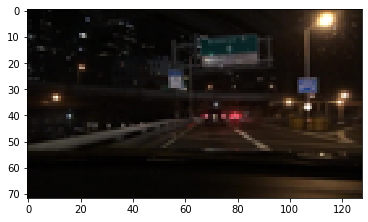

In [11]:
import matplotlib.pyplot as plt
plt.imshow(trainX[0])

In [12]:
from sklearn.preprocessing import QuantileTransformer
import cv2

# preprocessing for logistic regression
def pad_img(img, k=1): # creating a repeat of the boundary k times on 4 sides
    img = np.pad(img, ((k,k), (k,k)), 'edge')
    return img

def break_img(img, h=3, w=3): # break image into h x w chunks (doing 3x3 for now)
    height, width = img.shape
    A = np.zeros(((height - (h-1)) * (width - (w-1)), h*w))  
    # A is a matrix with each row as the chunk corresponding to the pixel at center of the chunk
    for i in range(h):
        for j in range(w):
            A[:, i * w + j] = np.reshape(
                img[i:height - (h-1) + i, j:width - (w-1) + j],
                ((height - (h-1)) * (width - (w-1)),))

    return np.array(A, dtype='uint8')

def lr_preprocessing(x, qt = None): # each image becomes an 9216x9 matrix A
    new_x = []
    for img in x:
        img = pad_img(img, 5)
        A = break_img(img, 11, 11)
        new_x.append(A)
    new_transform_x = np.array(new_x)
    return new_transform_x


def alt_lr_preprocessing(x, qt = None):
    new_x = []
    for img in x:
#         r, g, b = cv2.split(img)
#         r = pad_img(r, 5)
#         g = pad_img(g, 5)
#         b = pad_img(b, 5)
        img = pad_img(img, 5)
        A = break_img(r, 11, 11)
        new_x.append(A)
    new_transform_x = np.vstack(new_x)
    if qt is None:
        qt = QuantileTransformer(n_quantiles=255, output_distribution = 'normal')
        qt.fit(new_transform_x)
    return qt.transform(new_transform_x), qt
    
        

In [13]:
trainX, qt = alt_lr_preprocessing(trainX)
valX, _ = alt_lr_preprocessing(valX, qt)
testX, _ = alt_lr_preprocessing(testX, qt)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2)  and requested shape (3,2)

In [14]:
trainY = trainY.flatten()

In [15]:
valY = valY.flatten()
testY = testY.flatten()

In [16]:
# # unroll array for logistic regression
# # each image is an array
# def unroll(x, y):
#     x = x.reshape(x.shape[0] * x.shape[1], x.shape[2])
#     y = y.reshape(y.shape[0] * y.shape[1] * y.shape[2])
#     return x, y

In [17]:
# trainX, trainY = unroll(trainX, trainY)

# valX, valY = unroll(valX, valY)

# testX, testY = unroll(testX, testY)

IndexError: tuple index out of range

In [18]:
print(valY.shape)

(184320,)


In [19]:
print(valX.shape)

(184320, 121)


In [20]:
valX

array([[ 0.45978675,  0.45978675,  0.45978675, ...,  0.06419005,
        -0.2441862 ,  0.33164481],
       [ 0.45978675,  0.45978675,  0.45978675, ..., -0.25436628,
         0.33164481,  0.42712081],
       [ 0.45978675,  0.45978675,  0.45978675, ...,  0.32123607,
         0.42712081,  0.69319215],
       ...,
       [-1.11750251, -1.02970266, -0.97268746, ..., -0.79743774,
        -0.79743774, -0.79067467],
       [-1.02970266, -0.95696945, -0.97268746, ..., -0.79743774,
        -0.79743774, -0.79067467],
       [-0.96479866, -0.95696945, -0.93382591, ..., -0.79743774,
        -0.79743774, -0.79067467]])

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve, plot_precision_recall_curve
import pandas as pd

results = []

for norm in ['none', 'l1', 'l2']:
    for alpha in [.10, .25, .5, .75, 1]:
        print ("Norm={} Alpha={:.2f}".format(norm, alpha))
        if norm == 'none':
            lr = LogisticRegression(penalty=norm, max_iter=1000, solver='saga', class_weight = "balanced")
        else:
            lr = LogisticRegression(penalty=norm, C=alpha, max_iter=1000, solver='saga', class_weight = "balanced")
        lr.fit(trainX, trainY)
        
        predicted_labels = lr.predict(valX)
        acc = accuracy_score(valY, predicted_labels)
        precision = precision_score(valY, predicted_labels)
        recall = recall_score(valY, predicted_labels)
        print("Accuracy {:.5f}, Precision {:.5f}, Recall {:.5f}".format(acc, precision, recall))
        print()
        results.append([norm, alpha, acc])


Norm=none Alpha=0.10
Accuracy 0.56104, Precision 0.19903, Recall 0.43808

Norm=none Alpha=0.25
Accuracy 0.56104, Precision 0.19903, Recall 0.43808

Norm=none Alpha=0.50
Accuracy 0.56104, Precision 0.19903, Recall 0.43808

Norm=none Alpha=0.75
Accuracy 0.56104, Precision 0.19903, Recall 0.43808

Norm=none Alpha=1.00
Accuracy 0.56104, Precision 0.19903, Recall 0.43808

Norm=l1 Alpha=0.10
Accuracy 0.56130, Precision 0.19881, Recall 0.43679

Norm=l1 Alpha=0.25
Accuracy 0.56141, Precision 0.19920, Recall 0.43802

Norm=l1 Alpha=0.50
Accuracy 0.56117, Precision 0.19906, Recall 0.43793

Norm=l1 Alpha=0.75
Accuracy 0.56114, Precision 0.19908, Recall 0.43805

Norm=l1 Alpha=1.00
Accuracy 0.56112, Precision 0.19904, Recall 0.43796

Norm=l2 Alpha=0.10
Accuracy 0.56108, Precision 0.19904, Recall 0.43802

Norm=l2 Alpha=0.25
Accuracy 0.56109, Precision 0.19907, Recall 0.43811

Norm=l2 Alpha=0.50
Accuracy 0.56106, Precision 0.19904, Recall 0.43808

Norm=l2 Alpha=0.75
Accuracy 0.56106, Precision 0.19905

In [32]:
best_results = sorted(results, key = lambda x: x[2], reverse=True)
best_results

[['l1', 0.25, 0.5614149305555556],
 ['l1', 0.1, 0.5613009982638889],
 ['l1', 0.5, 0.5611707899305556],
 ['l1', 0.75, 0.5611382378472223],
 ['l1', 1, 0.5611165364583334],
 ['l2', 0.25, 0.5610894097222222],
 ['l2', 0.1, 0.5610785590277778],
 ['l2', 0.75, 0.5610622829861112],
 ['l2', 0.5, 0.5610568576388889],
 ['l2', 1, 0.5610514322916667],
 ['none', 0.1, 0.56103515625],
 ['none', 0.25, 0.56103515625],
 ['none', 0.5, 0.56103515625],
 ['none', 0.75, 0.56103515625],
 ['none', 1, 0.56103515625]]

In [34]:
norm = best_results[0][0]
alpha = best_results[0][1]

lr = LogisticRegression(penalty=norm, C=alpha, max_iter=1000, solver='saga', class_weight = "balanced")
lr.fit(trainX, trainY)

predicted_labels = lr.predict(valX)
acc = accuracy_score(valY, predicted_labels)
precision = precision_score(valY, predicted_labels)
recall = recall_score(valY, predicted_labels)
print("Accuracy {:.5f}, Precision {:.5f}, Recall {:.5f}".format(acc, precision, recall))

Accuracy 0.56141, Precision 0.19919, Recall 0.43799


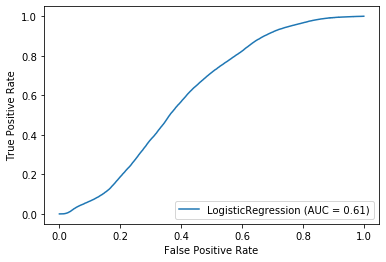

In [35]:
plot_roc_curve(lr, testX, testY)

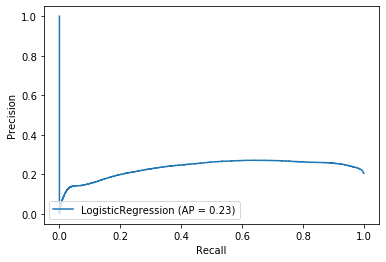

In [36]:
plot_precision_recall_curve(lr, testX, testY)

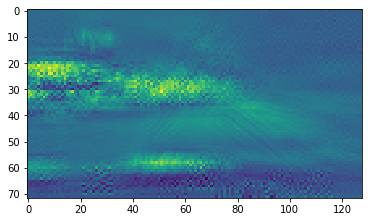

In [42]:
plt.imshow(lr.predict_proba(valX)[:,1].reshape(20, 72, 128)[2])

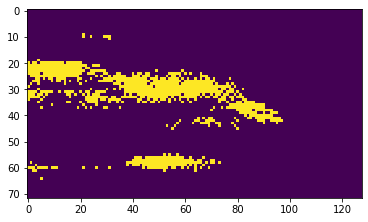

In [43]:
plt.imshow(lr.predict(valX).reshape(20, 72, 128)[2])

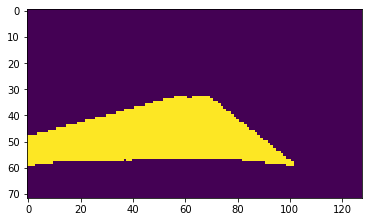

In [44]:
plt.imshow(valY.reshape(20, 72, 128)[2])

In [27]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd


#print ("Norm={} Alpha={:.2f}".format(norm, alpha))
SGD_
lr = SGDClassifier(class_weight = 'balanced')
lr.fit(trainX, trainY)
predicted_labels = lr.predict(valX)
acc = accuracy_score(valY, predicted_labels)
precision = precision_score(valY, predicted_labels)
recall = recall_score(valY, predicted_labels)
print("Accuracy {:.5f}, Precision {:.5f}, Recall {:.5f}".format(acc, precision, recall))
print()


NameError: name 'SGD_' is not defined